# A comparison of 10k cohort thrombolysis rates across hospitals, and comparison with hospital SHAP values

## Plain English summary

In response to stroke teams being told that they are performing differently from other, they often state that this is due to them having a different set of patients.

This does have some truth to it. For example the hospitals in London will have younger patients, arriving sooner than compared to hospitals in more rural locations.

In order to remove patient differences from results, a common 10k cohort of patients will be used with each of the hospital models. That way any difference is due to hospital factors, and not patient factors.

The predicted thrombolysis use in the 10k cohort of patients ranged from 10% to 45% across the 132 hospitals. The size of the hospital only accounted for 10% of the variation in thrombolysis use, and so there are other factors that account for the remaining 90%.

## Model and data

An XGBoost model is trained on all but a 10k patient cohort, to predict which patient will recieve thrombolysis.The 10k patient cohort is then used in two ways: 1) as the test set for the model fitting process 2) as a common set of patients that are sent to each hospital in turn to obtain a thrombolysis rate that is comparable across hosptials which has any patient factors removed.

The XGBoost model is fitted to all but 10k instances, and uses 8 features: 

* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Infarction: Stroke type (1 = infarction, 0 = haemorrhage)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Stroke team: Stroke team attended
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (1 = Yes, 0 = No)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)

And one target feature:
* Thrombolysis: Recieve thrombolysis (1 = Yes, 0 = No)

The 8 features included in the model (to predict whether a patient will recieve thrombolysis) were chosen sequentially as having the single best improvement in model performance (using the ROC AUC). The stroke team feature is included as a one-hot encoded feature.

## Aims:

* Train XGBoost model on all data except for a 10k set of patients
* Predict use of thrombolysis in the heldback 10k cohort of patients, at each of the 132 hospitals (by changing hospital one-hot coding).
* Compare the thrombolysis rate across the 132 hospitals. This can be seen as comparing the hospital effect, as the patient factors have been removed.
* Save thrombolysis rate at each hospital for the 10k patient cohort (for use in next notebook).

## Observations
* The 10k cohort model had an accuracy of 85.2%, in line with accuracy from k-fold testing (84.7%, see notebook 02).
* The predicted thrombolysis use in the 10k cohort of patients ranged from 10% to 45%.
* Only 10% of the variability in 10k hospital thrombolysis rate can be explained by the hospital admission rate.
* Nearly 92% of the variability in 10k hospital thrombolysis rate can be explained by the average hospital SHAP value.

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import shap
import copy

from scipy import stats

import pickle

from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.linear_model import LinearRegression

from xgboost import XGBClassifier

from os.path import exists
import json

## Set filenames

In [2]:
# Set model type (used in file save, e.g. xgb_combined_calibrated_oversampled)
number_key_features = 10
model_text = f'xgb_{number_key_features}_features_10k_cohort'
notebook = '04'

## Create output folders if needed

In [3]:
path = './saved_models'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './output'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './predictions'
if not os.path.exists(path):
    os.makedirs(path)

## Read in JSON file

Contains a dictionary for plain English feature names for the 8 features selected in the model. Use these as the column titles in the DataFrame.

In [4]:
with open("./output/01_feature_name_dict.json") as json_file:
    dict_feature_name = json.load(json_file)

## Load data

10k cohort of patients in test data, rest in training data

In [5]:
data_loc = '../data/10k_training_test/'

In [6]:
# Load data
train = pd.read_csv(data_loc + 'cohort_10000_train.csv')
test = pd.read_csv(data_loc + 'cohort_10000_test.csv')

# Read in the names of the selected features for the model
number_of_features_to_use = 10
key_features = pd.read_csv('./output/01_feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
# And add the target feature name: S2Thrombolysis
key_features.append('S2Thrombolysis')

# Select features
train = train[key_features]
train.rename(columns=dict_feature_name, inplace=True)
test = test[key_features]
test.rename(columns=dict_feature_name, inplace=True)

# KP DO WE NEED THESE?
# Save train and test stroke team column
train_stroke_team_ivt = train[['Stroke team', 'Thrombolysis']]
test_stroke_team_ivt = test[['Stroke team', 'Thrombolysis']]
all_data_stroke_team_ivt = pd.concat([test_stroke_team_ivt, train_stroke_team_ivt], axis=0)
all_data_stroke_team_ivt

,Stroke team,Thrombolysis
0,VUHVS8909F,0
1,HZNVT9936G,0
2,FAJKD7118X,1
3,TPXYE0168D,1
4,DNOYM6465G,0
...,...,...
78787,QWKRA8499D,1
78788,LLPWF6176Z,0
78789,SBYTE4026H,0
78790,LZGVG8257A,1


## Fit XGBoost model

Fit XGBoost model on the 10k cohort train/test dataset, and calculate model accuracy.

Save models.

In [7]:
# Fit models (True), or load models (False)
fit_models = False#True

# Get X and y
X_train = train.drop('Thrombolysis', axis=1)
X_test = test.drop('Thrombolysis', axis=1)
y_train = train['Thrombolysis']
y_test = test['Thrombolysis']

# One hot encode hospitals
X_train_hosp = pd.get_dummies(X_train['Stroke team'], prefix = 'team')
X_train = pd.concat([X_train, X_train_hosp], axis=1)
#X_train_stroke_team = X_train['Stroke team']
X_train.drop('Stroke team', axis=1, inplace=True)
X_test_hosp = pd.get_dummies(X_test['Stroke team'], prefix = 'team')
X_test = pd.concat([X_test, X_test_hosp], axis=1)
#X_test_stroke_team = X_test['Stroke team']
X_test.drop('Stroke team', axis=1, inplace=True)    

filename = (f'./saved_models/{notebook}_{model_text}.p')

# Fit model
if fit_models:
    # Define model
    model = XGBClassifier(verbosity=0, seed=42, learning_rate=0.5)
    model.fit(X_train, y_train)

    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(model, filehandler)
else:
    # Load models
    with open(filename, 'rb') as filehandler:
        model = pickle.load(filehandler)

# Get predicted probabilities and class
y_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)
#y_pred = y_prob > 0.5

# Show accuracy
accuracy = np.mean(y_pred == y_test)
print (f'Accuracy: {accuracy:.3f}')

Accuracy: 0.848


Calculate receiver operating characteristic curve area under curve.

In [8]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print (f'ROC ACUC: {roc_auc:.3f}')

ROC ACUC: 0.915


### Pass 10k cohort through all hospital models, get thrombolysis rate, SHAP values and SHAP interactions.

For each hospital, set all of the 10k patients in the test set as attending that hospital, and calculate the thrombolysis rate. This will give a thrombolysis rate for each hospital with patient variation removed, and only hospital factors remaining.

Also calculate the SHAP values and SHAP interactions.

In [9]:
hospitals = list(set(train['Stroke team']))
hospitals.sort()
thrombolysis_rate = []
single_predictions = []

# For each hospital
for hospital in hospitals:
    
    # Get test data without thrombolysis hospital or stroke team
    X_test_no_hosp = test.drop(['Thrombolysis', 'Stroke team'], axis=1)
    
    # Copy hospital dataframe and change hospital ID (after setting all to zero)
    X_test_adjusted_hospital = X_test_hosp.copy()
    X_test_adjusted_hospital.loc[:,:] = 0
    team = "team_" + hospital
    X_test_adjusted_hospital[team] = 1
    
    X_test_adjusted = pd.concat(
        [X_test_no_hosp, X_test_adjusted_hospital], axis=1)
    
    # Get predicted probabilities and class
    y_prob = model.predict_proba(X_test_adjusted)[:,1]
    y_pred = model.predict(X_test_adjusted)
#    y_pred = y_prob > 0.5
    thrombolysis_rate.append(y_pred.mean())
    
    # Save predictions
    single_predictions.append(y_pred * 1)

In [10]:
# Convert individual predictions (a list of arrays) to a NumPy array, and 
#   transpose
patient_results = np.array(single_predictions).T
# Convert to DataFrame
patient_results = pd.DataFrame(patient_results)
patient_results.to_csv(f'./output/{notebook}_{model_text}_individual_'
                       f'predictions.csv', 
                       index=False)

Sort by hospital 10k thrombolysis rate.

In [11]:
thrombolysis_by_hosp = pd.DataFrame(index=hospitals)
thrombolysis_by_hosp['Thrombolysis rate'] = thrombolysis_rate
thrombolysis_by_hosp.sort_values(
    'Thrombolysis rate', inplace=True, ascending=False)

# Save
thrombolysis_by_hosp.to_csv(
    f'./output/{notebook}_{model_text}_thrombolysis_rate_by_hosp.csv', 
    index_label='stroke_team')

### Plot thrombolysis rate of 10k cohort at each hospital

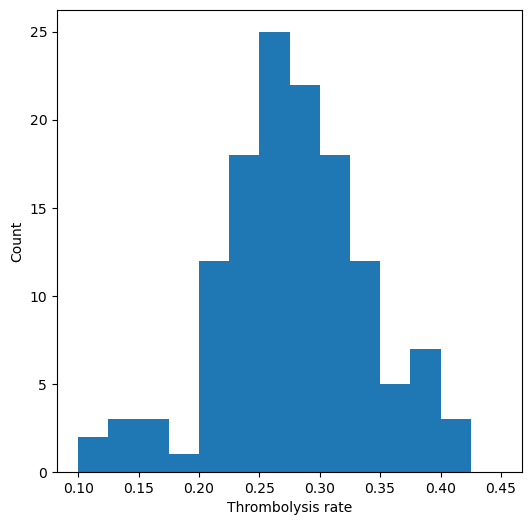

In [12]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.hist(thrombolysis_rate, bins=np.arange(0.10, 0.46, 0.025))
ax.set_xlabel('Thrombolysis rate')
ax.set_ylabel('Count')
plt.show()

### Show stats

In [13]:
mean = np.mean(thrombolysis_by_hosp['Thrombolysis rate'])
stdev = np.std(thrombolysis_by_hosp['Thrombolysis rate'])
minimum = np.min(thrombolysis_by_hosp['Thrombolysis rate'])
maximum = np.max(thrombolysis_by_hosp['Thrombolysis rate'])

print (f'Mean: {mean:0.3f}')
print (f'StDev: {stdev:0.3f}')
print (f'Min: {minimum:0.3f}')
print (f'Max{maximum:0.3f}')

Mean: 0.280
StDev: 0.063
Min: 0.101
Max0.453


## Compare level of agreement between hospitals 

In this section we look at how many hospitals agree on whether to give each patient in the 10k cohort thrombolysis or not.

Collating individual predictions:

In [14]:
# Set up data frame and get the number and percent hopsitals giving thrombolysis
agreement = pd.DataFrame()
agreement['sum'] = patient_results.sum(axis=1)
agreement['percent'] = agreement['sum'] * 100 / patient_results.shape[1]
# Percent agree can be to give thrombolysis (p) or not (100-p)
agreement['percent_agree'] = [max(p, 100-p) for p in agreement['percent']]
# Add in whether thrombolysis was actually given
agreement['True'] = y_test

Plot results:

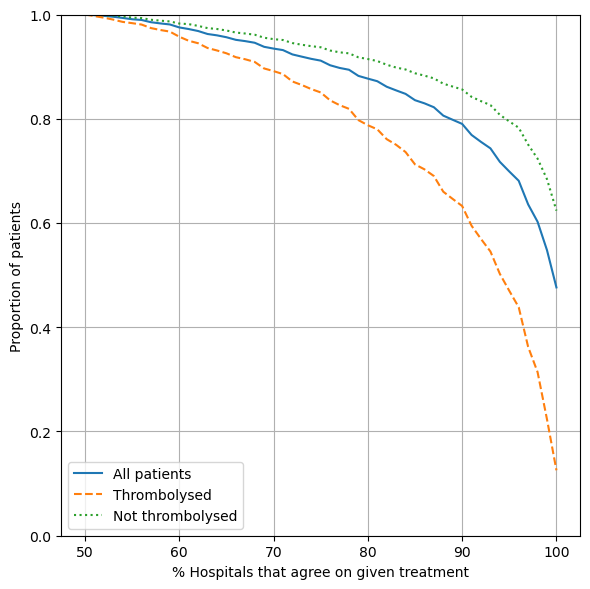

In [15]:
fig = plt.figure(figsize=(6,6))

# Agreement on treatment 
ax1 = fig.add_subplot(111)
xvals = np.arange(50,101,1)

y1 = [sum([1 for p in agreement.percent_agree.values if p>=x])\
         /len(agreement.percent_agree.values) for x in xvals]

ax1.plot(xvals, y1, label='All patients', linestyle='-')

y2 = [sum(1 for p in agreement[agreement['True']==1].percent_agree.values if p>=x)\
         /len(agreement[agreement['True']==1].percent_agree.values) for x in xvals]

ax1.plot(xvals, y2, label='Thrombolysed', linestyle='--')

y3 = [sum(1 for p in agreement[agreement['True']==0].percent_agree.values if p>=x)\
         /len(agreement[agreement['True']==0].percent_agree.values) for x in xvals]
      
ax1.plot(xvals, y3, label='Not thrombolysed', linestyle=':')
         
ax1.legend()

ax1.set_xlabel('% Hospitals that agree on given treatment')
ax1.set_ylabel('Proportion of patients')
ax1.set_ylim(0, 1)
ax1.grid()
      
plt.tight_layout()
plt.savefig(
        f'./output/{notebook}_{model_text}_agreement_vs_hospital_single.jpg', 
        dpi=300)
plt.show()

Show statistics:

In [16]:
# Set percent of hospital to agree
xvals = [80, 90, 95]

# Find proportion of patients with agreement for either treat/no-treat decsion
agree_all = [sum([1 for p in agreement.percent_agree.values if p>=x])\
         /len(agreement.percent_agree.values) for x in xvals]

# Find proportion of thrombolysed patients with agreement
agree_thromb = [
    sum(1 for p in agreement[agreement['True']==1].percent_agree.values if p>=x)\
         /len(agreement[agreement['True']==1].percent_agree.values) for x in xvals]

# Find proportion of non-thrombolysed patients with agreement
agree_non_thromb = [
    sum(1 for p in agreement[agreement['True']==0].percent_agree.values if p>=x)\
         /len(agreement[agreement['True']==0].percent_agree.values) for x in xvals]

# Put in DataFrame
results_agree = pd.DataFrame()
results_agree['% Hospitals Agree'] = xvals
results_agree.set_index('% Hospitals Agree', inplace=True)
results_agree['Any'] = agree_all
results_agree['Patient thrombolysed'] = agree_thromb
results_agree['Patient not thrombolysed'] = agree_non_thromb
results_agree = results_agree.round(3)

results_agree

,Any,Patient thrombolysed,Patient not thrombolysed
% Hospitals Agree,,,
80,0.877,0.788,0.915
90,0.790,0.633,0.856
95,0.699,0.470,0.795


In the table above, for example, 87.4% of patients have 80% of hospitals agree on treatment. For those patients that did actually receive thrombolysis, 78.8% of patients have 80% of hospitals agree to thrombolyse. For those patients that did not actually receive thrombolysis, 91.1% of patients have 80% of hospitals agree not to thrombolyse. 

## Compare SHAP value (and main effect) for the hospital feature, with the predicted 10k thrombolysis rate

The hospital feature is one hot encoded, so there is a SHAP value per stroke team. We will use this to create two plots:

1) histogram of the frequency of the SHAP value (and main effect) for the hospital feature
2) scatter plot of SHAP value (and main effect) vs thrombolysis rate (on 10K cohort) for each hospital

### Get SHAP values

Either set up method to estimate SHAP values, or if already created then load from pickle.

In [17]:
%%time

# Set up method to estimate SHAP values for tree models and ensembles of trees
filename = (f'./output/{notebook}_{model_text}_shap_explainer_'
            f'object.p')
file_exists = exists(filename)

if file_exists:
    # Load SHAP explainer
    with open(filename, 'rb') as filehandler:
        explainer = pickle.load(filehandler)
else:
    # Get SHAP explainer (using the model and feature values from training set)
    explainer = shap.TreeExplainer(model, X_train)
    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(explainer, filehandler)

CPU times: user 15.2 ms, sys: 0 ns, total: 15.2 ms
Wall time: 14.8 ms


Initialise dictionaries to store shap_values_extended per hospital

In [18]:
# Initialise dictionary to store shap_values per hospital.
dict_shap_values_extended = {}

# Get SHAP values
filename = (f'./output/{notebook}_{model_text}_dict_shap_values_'
            f'explainer_object.p')
file_exists = exists(filename)

if file_exists:
    # Load SHAP values (in a dictionary, using hospital as a key
    with open(filename, 'rb') as filehandler:
        dict_shap_values_extended = pickle.load(filehandler)
else:

    # For each hospital calculate SHAP values for the test set (all going to each hospital)
    count = 0
    for hospital in hospitals:
        # Print progress
        count += 1
        print (f"Calculating SHAP for hospital {count} of {len(hospitals)}")
        
        # Get test data without thrombolysis hospital or stroke team
        X_test_no_hosp = test.drop(['Thrombolysis', 'Stroke team'], axis=1)

        # Copy hospital dataframe and change hospital ID (after setting all to zero)
        X_test_adjusted_hospital = X_test_hosp.copy()
        X_test_adjusted_hospital.loc[:,:] = 0
        team = "team_" + hospital
        X_test_adjusted_hospital[team] = 1

        X_test_adjusted = pd.concat(
            [X_test_no_hosp, X_test_adjusted_hospital], axis=1)

        # Get SHAP values (along with base and feature values)
        shap_values_extended = explainer(X_test_adjusted)
        
        # Add to overall shap_values_extended
        dict_shap_values_extended[f"{hospital}"] = shap_values_extended
        #shap_values_extended.values ADD TO hosp_shap_values_extended.values
        #shap_values_extended.data ADD TO hosp_shap_values_extended.data
        #shap_values_extended.base_value ADD TO hosp_shap_values_extended.base_value
        
    # Save the shap_values+extended dictionary
    with open(filename, 'wb') as filehandler:
        pickle.dump(dict_shap_values_extended, filehandler)

# Extract SHAP values
#shap_values = shap_values_extended.values

#### Format the SHAP values data

Features are in the same order in shap_values as they are in the original dataset.

Use this fact to extract the SHAP values for the one-hot encoded hospital features. Create a dataframe containing the SHAP values: an instance per row, and a one-hot encoded hospital feature per column.

Also include a column containing the Stroke team that each instance attended.

And three further columns:

contribution from all the hospital features
contribution from attending the hospital
contribution from not attending the rest


In [19]:
#save
filename = f'./output/{notebook}_{model_text}_SHAP_values.csv'
file_exists = exists(filename)

if file_exists:
    df_hosp_shap_values = pd.read_csv(filename)
else:
    # Get list of hospital one hot encoded column titles
    hospitals_ohe = X_test.filter(regex='^team',axis=1).columns
    n_hospitals = len(hospitals_ohe)

    # Create list of column index for these hospital column titles
    hospital_columns_index = [X_test.columns.get_loc(col) for col in hospitals_ohe]

    # Create column titles
    columns = copy.deepcopy(hospitals)
    columns.append("Stroke team")
    columns.append("All stroke teams")
    columns.append("Attended stroke team")
    columns.append("Not attended stroke teams")

    # Initialise empty dataframe with these titles
    df_hosp_shap_values = pd.DataFrame(columns=columns)

    # For each hospital
    for hospital in hospitals:
    #    print (f"Joining SHAP for hospital {count} of {len(hospitals)}")
        # Get hospital SHAP values extended
        shap_values_extended = dict_shap_values_extended[f"{hospital}"]

        # Use the index list to access the hosptial shap values (as array)
        hosp_shap_values = shap_values_extended.values[:,hospital_columns_index]
        # Put in dataframe with hospital as column title
        df_temp = pd.DataFrame(hosp_shap_values, columns = hospitals)

        # Store the sum of the SHAP values (for all of the hospital features)
        df_temp["All stroke teams"] = df_temp.sum(axis=1)

        # Store which hospital patient went to
        df_temp["Stroke team"] = hospital

        # Store the SHAP values for the hospital attended
        df_temp["Attended stroke team"] = df_temp[f"{hospital}"]

        # Store the sum of the SHAP values for all of the hospitals not attended
        df_temp["Not attended stroke teams"] = (df_temp["All stroke teams"] - 
                                                df_temp["Attended stroke team"])

        # Add to master DataFrame
        df_hosp_shap_values = pd.concat([df_hosp_shap_values, df_temp], axis=0)

# View preview
df_hosp_shap_values.head()

,AGNOF1041H,AKCGO9726K,AOBTM3098N,APXEE8191H,ATDID5461S,BBXPQ0212O,BICAW1125K,BQZGT7491V,BXXZS5063A,CNBGF2713O,...,YEXCH8391J,YPKYH1768F,YQMZV4284N,ZBVSO0975W,ZHCLE1578P,ZRRCV7012C,Stroke team,All stroke teams,Attended stroke team,Not attended stroke teams
0,0.346294,-0.003586,0.0,0.000000,0.0,0.0,0.0,-0.008723,0.0,0.0,...,0.0,0.0,-0.006462,0.009641,0.0,0.0,AGNOF1041H,0.328467,0.346294,-0.017827
1,0.020056,-0.022589,0.0,0.000000,0.0,0.0,0.0,-0.007895,0.0,0.0,...,0.0,0.0,-0.002869,0.009464,0.0,0.0,AGNOF1041H,-0.081610,0.020056,-0.101666
2,-0.154946,-0.005871,0.0,0.000000,0.0,0.0,0.0,-0.001841,0.0,0.0,...,0.0,0.0,-0.003350,0.009117,0.0,0.0,AGNOF1041H,-0.266755,-0.154946,-0.111809
3,0.159131,-0.010690,0.0,0.000000,0.0,0.0,0.0,-0.016698,0.0,0.0,...,0.0,0.0,-0.003343,0.009693,0.0,0.0,AGNOF1041H,0.125183,0.159131,-0.033947
4,-0.115854,-0.012736,0.0,-0.002466,0.0,0.0,0.0,-0.007800,0.0,0.0,...,0.0,0.0,-0.002686,0.004752,0.0,0.0,AGNOF1041H,-0.221535,-0.115854,-0.105681


Code used to get SHAP interactions. Needed to set up explainer without X_train. Investigate why later. Gave error "EATURE_DEPENDENCE::independent does not support interactions!" when included X_train in the explainer. Didn't understand the explanations for this error when I googled it. It was raised as an issue for SHAP library.

CODE:

explainer = shap.TreeExplainer(model)#, X_train)
shap_interaction = explainer.shap_interaction_values(X_test)

# Save using pickle
with open(filename, 'wb') as filehandler:
    pickle.dump(shap_interaction, filehandler)  

### Get SHAP interaction values
Use the TreeExplainer to also calculate the SHAP main effect and SHAP interaction values (the sum of which give the SHAP values for each feature)

A SHAP interaction value is returned for each pair of features (including with itself, which is known as the main effect), for each instance. The SHAP value for a feature is the sum of it's pair-wise feature interactions.

Use these values to access the main effect for each of the one-hot encoded hospital features.

Either load from pickle (if file exists), or calculate.

#### At the same tiume: Format the SHAP interaction data so only get the main effect for the hospital features

Features are in the same order in shap_interaction as they are in the original dataset.

Use this fact to extract the SHAP main effect values for the one-hot encoded hospital features. Create a dataframe containing the SHAP values: an instance per row, and a one-hot encoded hospital feature per column.

Also include a column containing the Stroke team that each instance attended.

And three further columns:
1. contribution from all the hospital features
2. contribution from attending the hospital
3. contribution from not attending the rest

SHAP interaction values have a matrix of values (per pair of features) per instance.

For each hospital, have the 10k instances each with a 139x139 matrix of SHAP interaction values (with the SHAP main effect on the diagonal positions).

Once get the SHAP interaction values, get the main effects for just the hosptial features and store these in a row in a dataframe. So the dataframe has a row per instance and a hospital per column with each value being the main effect for that feature.

In [20]:
%%time

#filename = f'./output/{notebook}_{model_text}_shap_interaction_array.p'
filename = f'./output/{notebook}_{model_text}_shap_main_effects_df.p'
file_exists = exists(filename)

if file_exists:
    # Load SHAP interaction array
    with open(filename, 'rb') as filehandler:
        df_hosp_shap_main_effects = pickle.load(filehandler)
else:
    # Get list of hospital one hot encoded column titles
    hospitals_ohe = X_test.filter(regex='^team',axis=1).columns
    n_hospitals = len(hospitals_ohe)

    # Create list of column index for these hospital column titles
    hospital_columns_index = [X_test.columns.get_loc(col) for col in hospitals_ohe]

    explainer = shap.TreeExplainer(model)#, X_train)

    # For each hospital calculate SHAP values for the test set (all going to each hospital)
    count = 0
    for hospital in hospitals:
        # Print progress
        count += 1
        print (f"Calculating SHAP main effect for hospital {count} of {len(hospitals)}")

        # Get test data without thrombolysis hospital or stroke team
        X_test_no_hosp = test.drop(['Thrombolysis', 'Stroke team'], axis=1)

        # Copy hospital dataframe and change hospital ID (after setting all to zero)
        X_test_adjusted_hospital = X_test_hosp.copy()
        X_test_adjusted_hospital.loc[:,:] = 0
        team = "team_" + hospital
        X_test_adjusted_hospital[team] = 1

        X_test_adjusted = pd.concat(
            [X_test_no_hosp, X_test_adjusted_hospital], axis=1)

        # Get SHAP values (along with base and feature values)
        hosp_shap_interaction = explainer.shap_interaction_values(X_test_adjusted)
        
        
        # Use this index list to access the hosptial shap values (as array) in the loop below
        hosp_shap_main_effects = []
        for i in range(hosp_shap_interaction.shape[0]):
        # Get the main effect value for each of the features
            main_effects = np.diagonal(hosp_shap_interaction[i])
            hosp_shap_main_effects.append(main_effects[hospital_columns_index])
        
        # Put in dataframe with hospital as column title
        df_temp = pd.DataFrame(hosp_shap_main_effects, columns=hospitals)

        # Store the sum of the SHAP values (for all of the hospital features)
        df_temp["All stroke teams"] = (df_temp.sum(axis=1))

        # Include Stroke team that each instance attended
        df_temp["Stroke team"] = hospital

        # Store the SHAP values for the hospital attended
        df_temp["Attended stroke team"] = df_temp[f"{hospital}"]

        # Store the sum of the SHAP values for all of the hospitals not attended
        df_temp["Not attended stroke teams"] = (
                            df_temp["All stroke teams"] - 
                            df_temp["Attended stroke team"])

        if hospital == hospitals[0]:
            # For first hospital, make the tuple collecting a copy of the hfirst hospitl, others will be added to this.
            df_hosp_shap_main_effects = df_temp.copy(deep=True)
        else:
            # Add to master DataFrame
            df_hosp_shap_main_effects = pd.concat(
                            [df_hosp_shap_main_effects, df_temp], 
                            axis=0) 

    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(df_hosp_shap_main_effects, filehandler) 

CPU times: user 19.4 ms, sys: 304 ms, total: 323 ms
Wall time: 323 ms


### Boxplot (all hospitals together)

Analyse the range of SHAP values amd SHAP main effect values for the one-hot encoded hospital features. Show as two populations: the attended hospital, the sum of the hospitals not attended

To create a grouped boxplot, used code from https://stackoverflow.com/questions/16592222/matplotlib-group-boxplots

In [21]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
    return()

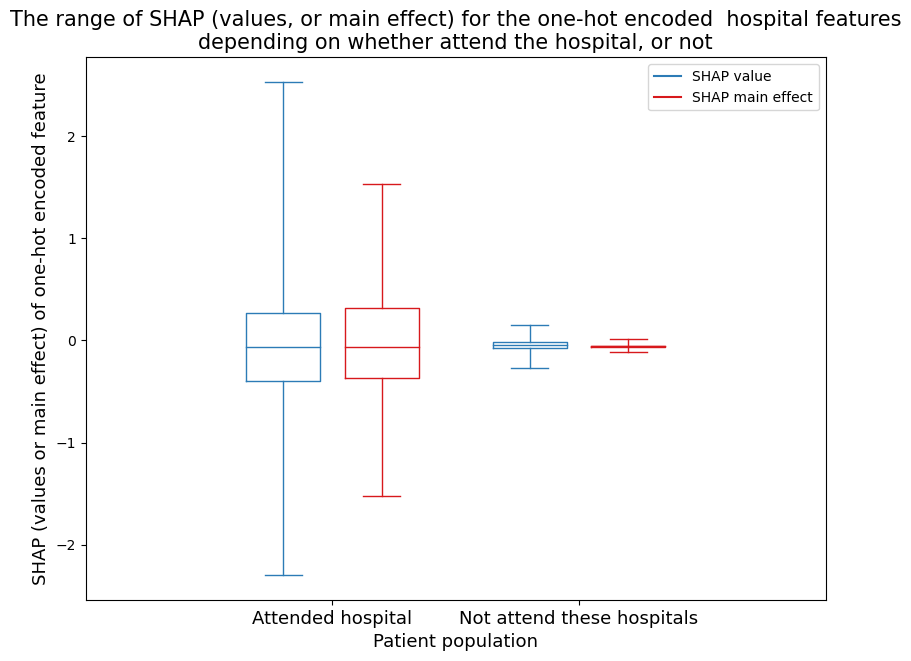

In [22]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ticks = ["Attended hospital", "Not attend these hospitals"]

plot_data_sv = [df_hosp_shap_values["Attended stroke team"], 
                df_hosp_shap_values["Not attended stroke teams"]]

bp_sv = plt.boxplot(plot_data_sv, 
                  positions=np.array(range(len(plot_data_sv)))*2.0-0.4, 
                  sym='', whis=99999, widths=0.6)
set_box_color(bp_sv, '#2C7BB6')

plot_data_me = [df_hosp_shap_main_effects["Attended stroke team"], 
                df_hosp_shap_main_effects["Not attended stroke teams"]]
bp_me = plt.boxplot(plot_data_me, 
                  positions=np.array(range(len(plot_data_me)))*2.0+0.4, 
                  sym='', whis=99999, widths=0.6)
set_box_color(bp_me, '#D7191C') # colors are from http://colorbrewer2.org/

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#2C7BB6', label='SHAP value')
plt.plot([], c='#D7191C', label='SHAP main effect')
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks, size=13)
plt.xlim(-2, len(ticks)*2)
plt.tight_layout()

title = ("The range of SHAP (values, or main effect) for the one-hot encoded "
         " hospital features\ndepending on whether attend the hospital, or not")
plt.title(title, size=15)
plt.ylabel('SHAP (values or main effect) of one-hot encoded feature', size=13)
plt.xlabel('Patient population', size=13)
plt.savefig(f'./output/{notebook}_{model_text}'
            f'_hosp_shap_value_and_maineffect_attend_vs_notattend_boxplot.jpg', 
            dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

### Boxplot (individual hospitals)
Create a boxplot to show the range of SHAP values and SHAP main effect values for each individual one-hot encoded hospital feature.

Show the SHAP value as two populations: 1) the group of instances that attend the hospital [black], and 2) the group of instances that do not attend the hosptial [orange].

Order the hospitals in descending order of median SHAP value for the hospital the instance attended (so those that more often contribute to a yes-thrombolysis decision, through to those that most often contribute to a no-thrombolysis decision).

Firstly, to order the hospitals, create a dataframe containing the median SHAP main effect, and median SHAP values for each hosptial (for those instances that attended the hospital)

In [23]:
def shap_descriptive_stats(hospital_names, df_hosp_shap, prefix_text):
    # Create list of SHAP main effect values (one per hospital) for those instances
    #   that attend the hospital
    attend_stroketeam_min = []
    attend_stroketeam_q1 = []
    attend_stroketeam_median = []
    attend_stroketeam_q3 = []
    attend_stroketeam_max = []
    for h in hospital_names:
        mask = df_hosp_shap['Stroke team'] == h
        data_stroke_team = df_hosp_shap[h][mask]
        q1, q3 = np.percentile(data_stroke_team, [25,75])
        attend_stroketeam_min.append(data_stroke_team.min())
        attend_stroketeam_q1.append(q1)
        attend_stroketeam_median.append(data_stroke_team.median())
        attend_stroketeam_q3.append(q3)
        attend_stroketeam_max.append(data_stroke_team.max())

    # Create dataframe with six columns (hospital and descriptive stats)
    df = pd.DataFrame(hospital_names, columns=[f"hospital_{prefix_text}"])
    df[f"shap_min_{prefix_text}"] = attend_stroketeam_min
    df[f"shap_q1_{prefix_text}"] = attend_stroketeam_q1
    df[f"shap_median_{prefix_text}"] = attend_stroketeam_median
    df[f"shap_q3_{prefix_text}"] = attend_stroketeam_q3
    df[f"shap_max_{prefix_text}"] = attend_stroketeam_max
    
    return(df)

In [24]:
df_me = shap_descriptive_stats(hospitals, df_hosp_shap_main_effects, "me")
df_sv = shap_descriptive_stats(hospitals, df_hosp_shap_values, "sv")

df_hosp_shap_descriptive_stats = df_me.join(df_sv)
df_hosp_shap_descriptive_stats.drop(columns=["hospital_sv"], inplace=True)
df_hosp_shap_descriptive_stats.rename(columns={"hospital_me": "hospital"}, 
                                      inplace=True)

Sort in descending SHAP main effect value order

In [25]:
df_hosp_shap_descriptive_stats.sort_values("shap_median_me", 
                                           ascending=False, inplace=True)                
df_hosp_shap_descriptive_stats.head(5)

,hospital,shap_min_me,shap_q1_me,shap_median_me,shap_q3_me,shap_max_me,shap_min_sv,shap_q1_sv,shap_median_sv,shap_q3_sv,shap_max_sv
9,CNBGF2713O,0.958873,1.212353,1.268368,1.329043,1.532164,-0.115890,0.706332,1.015807,1.341116,2.194533
109,VKKDD9172T,0.757424,1.046197,1.122346,1.185386,1.464610,0.161343,0.998213,1.320780,1.689903,2.527115
25,GKONI0110I,0.657628,0.967990,1.013595,1.059107,1.339179,-0.111562,0.652781,0.910069,1.094527,1.794004
32,HPWIF9956L,0.656201,0.931542,1.003493,1.076609,1.324047,0.014943,0.749513,1.148267,1.445199,2.115388
65,NTPQZ0829K,0.583794,0.877956,0.913931,0.956586,1.169348,-0.136511,0.662457,0.971589,1.114202,1.600292


Use 10k thrombolysis rate from the model output.

In [26]:
thrombolysis_by_hosp

,Thrombolysis rate
VKKDD9172T,0.4527
GKONI0110I,0.4132
HPWIF9956L,0.4131
CNBGF2713O,0.4093
TPXYE0168D,0.3962
...,...
LECHF1024T,0.1478
LGNPK4211W,0.1445
OUXUZ1084Q,0.1295
HZMLX7970T,0.1149


Create data for boxplot

In [27]:
# Go through to order of hospital in
hospital_order = df_hosp_shap_descriptive_stats["hospital"]
    
# Create list of SHAP main effect values (one per hospital) for instances that 
#   attend stroke team
me_attend_stroketeam_groups_ordered = []
sv_attend_stroketeam_groups_ordered = []    
# Create list of SHAP main effect values (one per hospital) for instances that 
#   do not attend stroke team
me_not_attend_stroketeam_groups_ordered = []
sv_not_attend_stroketeam_groups_ordered = []
# Create list of labels for boxplot "stroke team name (admissions)"
xlabel = []

# Through hospital in defined order (as determined above)
for h in hospital_order:
    # Attend
    mask = df_hosp_shap_main_effects['Stroke team'] == h
    me_attend_stroketeam_groups_ordered.append(
                                            df_hosp_shap_main_effects[h][mask])
    mask = df_hosp_shap_values['Stroke team'] == h
    sv_attend_stroketeam_groups_ordered.append(df_hosp_shap_values[h][mask])
    # Not attend
    mask = df_hosp_shap_main_effects['Stroke team'] != h
    me_not_attend_stroketeam_groups_ordered.append(
                                            df_hosp_shap_main_effects[h][mask])
    mask = df_hosp_shap_values['Stroke team'] == h
    sv_not_attend_stroketeam_groups_ordered.append(df_hosp_shap_values[h][mask])
    # Label
    xlabel.append(f"{h} ({round(thrombolysis_by_hosp['Thrombolysis rate'].loc[h] * 100, 0)}%)")

Resource for using overall y min and max of both datasets on the 4 plots so have the same range https://blog.finxter.com/how-to-find-the-minimum-of-a-list-of-lists-in-python/#:~:text=With%20the%20key%20argument%20of,of%20the%20list%20of%20lists.

Shows the range of contributions to the prediction from this hospital when patients attend this hosptial


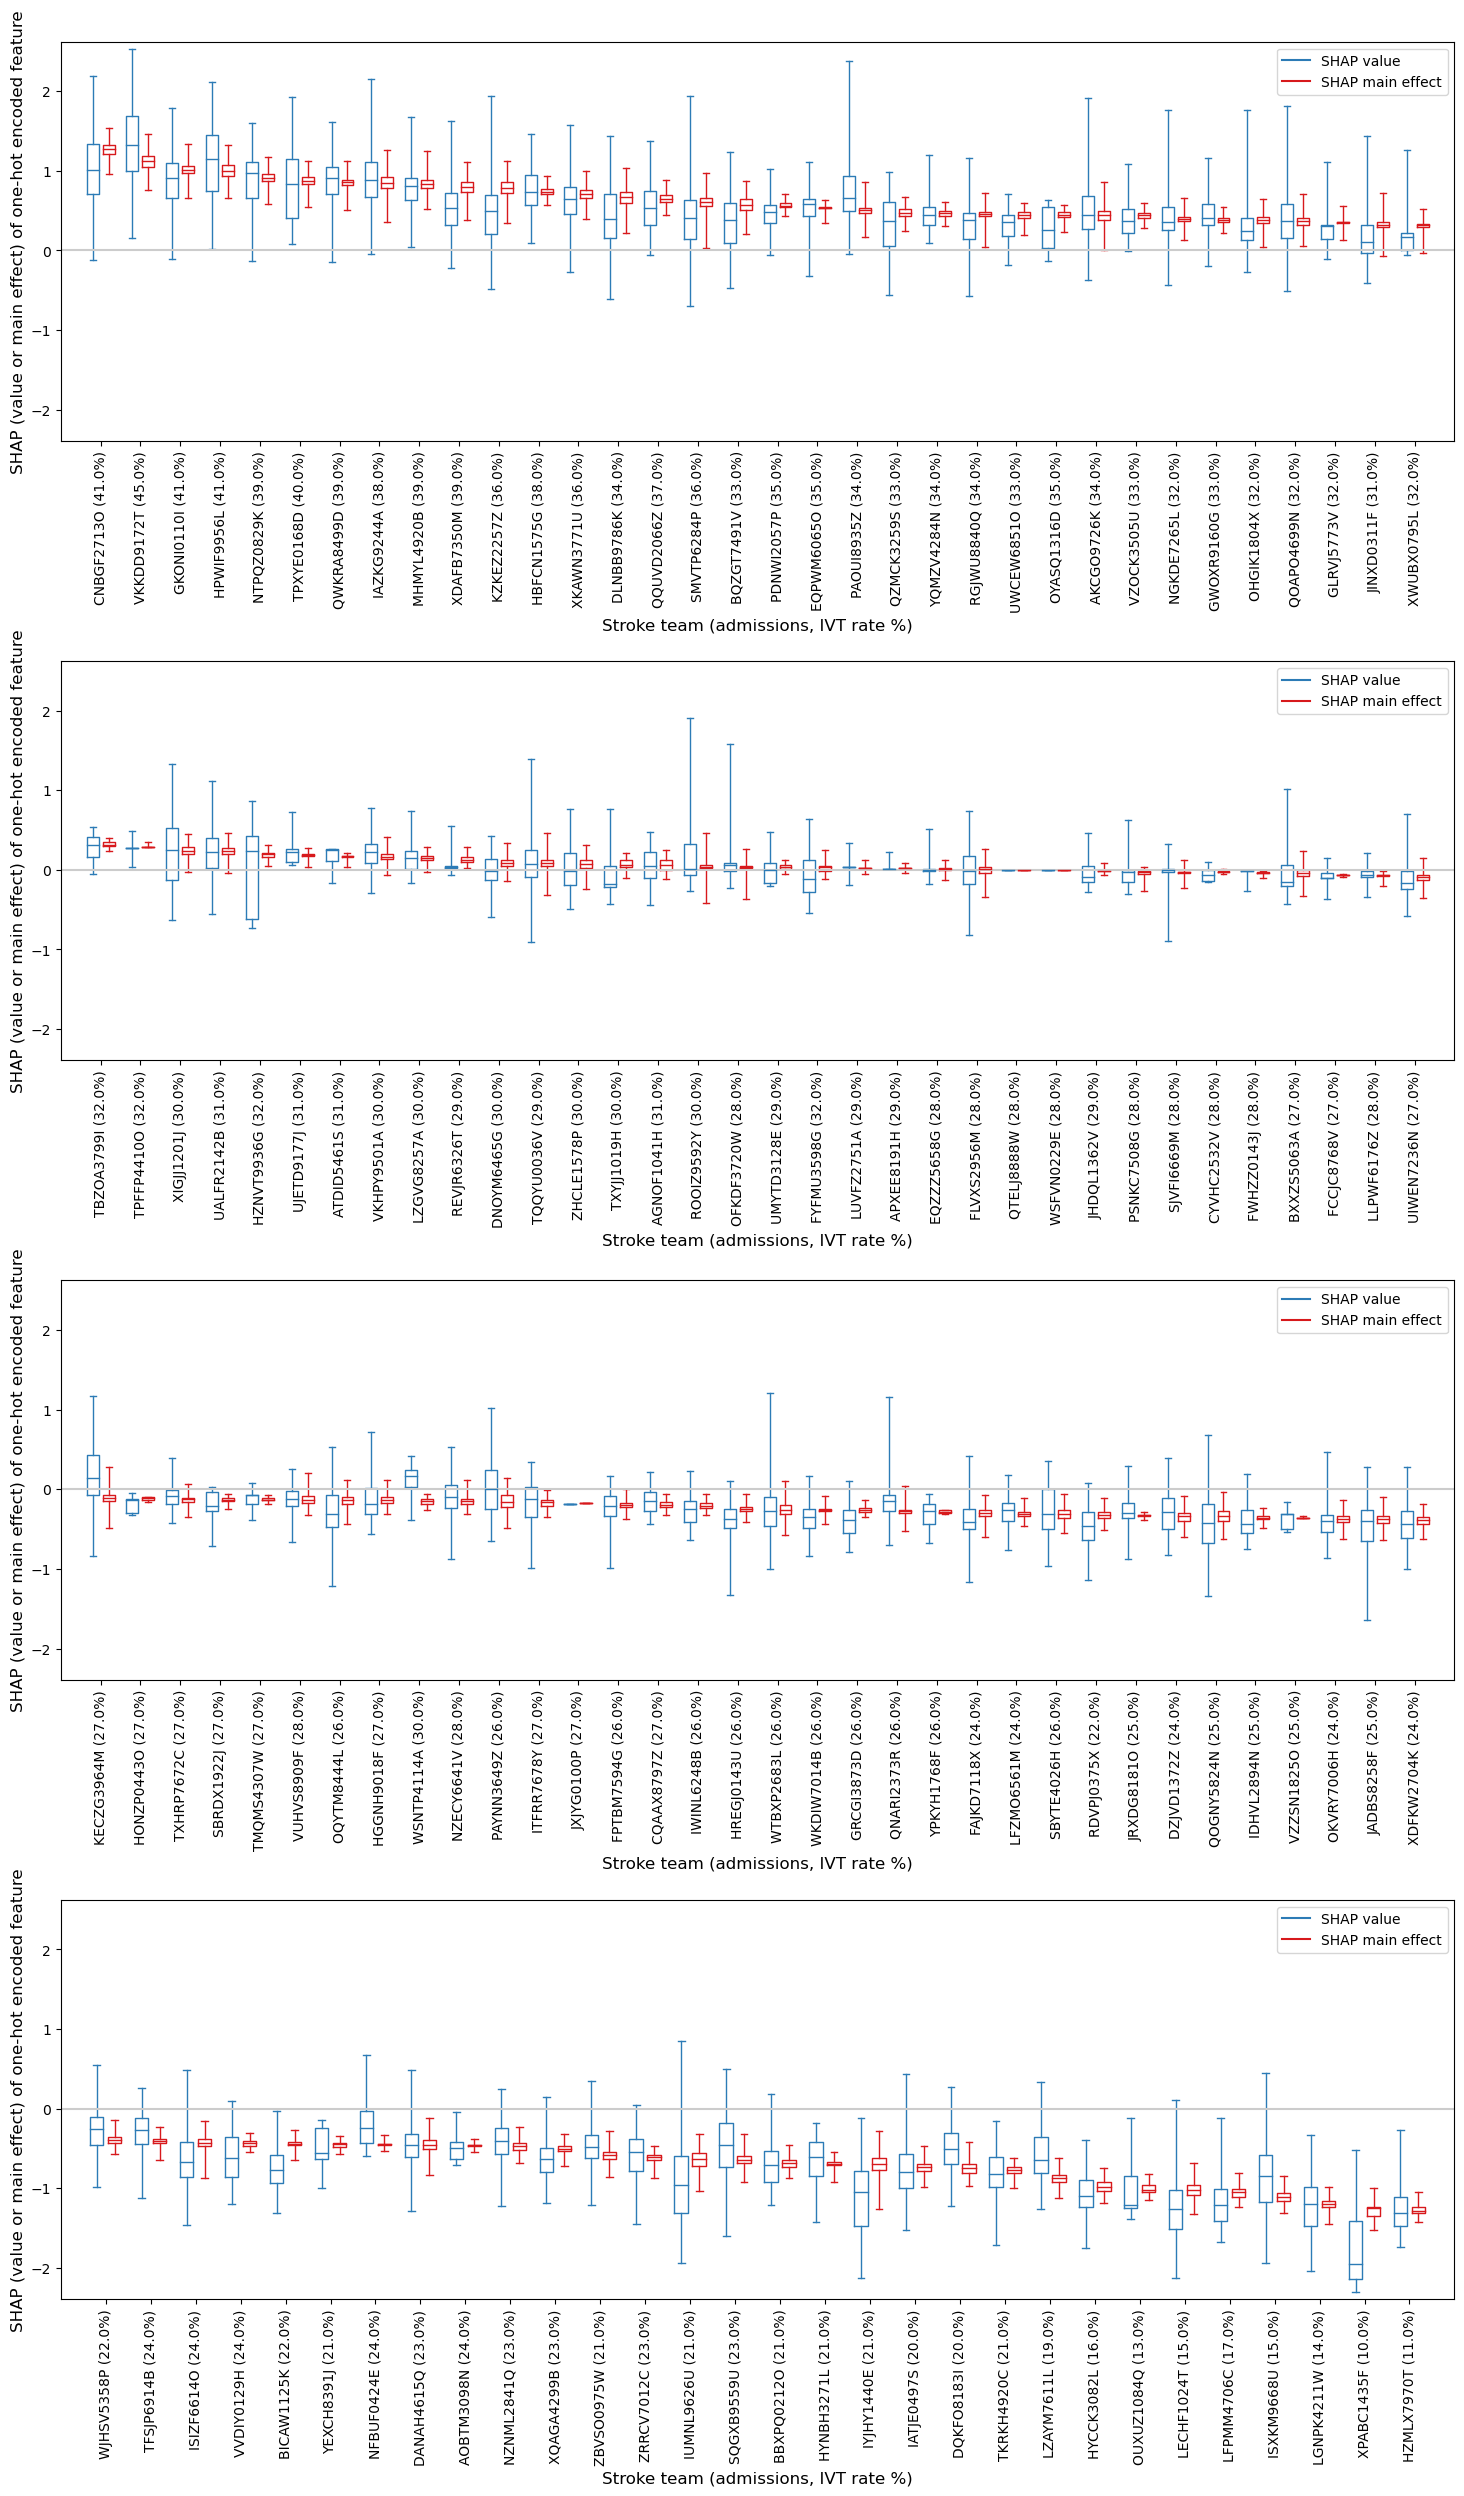

In [28]:
# Plot 34 hospitals on each figure to aid visually
print("Shows the range of contributions to the prediction from this hospital "
      "when patients attend this hosptial")

# To group the hospitals into 34
st = 0
ed = 34
inc = ed
max_size = len(hospitals)

# Use overall y min & max of both datasets on the 4 plots so have same range
ymin = min(min(sv_attend_stroketeam_groups_ordered, key=min))
ymax = max(max(sv_attend_stroketeam_groups_ordered, key=max))

# Adjust min and max to accommodate some wriggle room
yrange = ymax - ymin
ymin = ymin - yrange/50
ymax = ymax + yrange/50

# Create figure with 4 subplots
fig = plt.figure(figsize=(15,25))

# Create four subplots
for subplot in range(4):
    ax = fig.add_subplot(4,1,subplot+1)
    
    # "The contribution from this hospital when patients do not attend this hosptial"
    ticks = xlabel[st:ed]#hospital_order[st:ed]
    
    pos_sv = np.array(range(
                    len(sv_attend_stroketeam_groups_ordered[st:ed])))*2.0-0.4
    bp_sv = plt.boxplot(sv_attend_stroketeam_groups_ordered[st:ed], 
                        positions=pos_sv, sym='', whis=99999, widths=0.6)
    
    pos_me = np.array(range(len(
                        me_attend_stroketeam_groups_ordered[st:ed])))*2.0+0.4
    bp_me = plt.boxplot(me_attend_stroketeam_groups_ordered[st:ed], 
                        positions=pos_me, sym='', whis=99999, widths=0.6)
    
    # colors are from http://colorbrewer2.org/
    set_box_color(bp_me, '#D7191C') 
    set_box_color(bp_sv, '#2C7BB6')

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='#2C7BB6', label='SHAP value')
    plt.plot([], c='#D7191C', label='SHAP main effect')
    plt.legend()

    plt.xticks(range(0, len(ticks) * 2, 2), ticks)
    plt.xlim(-2, len(ticks)*2)
    plt.ylim(ymin, ymax)
    plt.tight_layout()
    
    # Add line at Shap = 0
    plt.plot([plt.xlim()[0], plt.xlim()[1]], [0,0], c='0.8') 
    
    plt.ylabel('SHAP (value or main effect) of one-hot encoded feature', size=12)
    plt.xlabel('Stroke team (admissions, IVT rate %)', size=12)
    plt.xticks(rotation=90)
    st = min(st+inc,max_size)
    ed = min(ed+inc,max_size)
    
plt.subplots_adjust(bottom=0.25, wspace=0.05)    
plt.tight_layout(pad=2)
plt.savefig(f'./output/{notebook}_{model_text}_individual_hosp_shap_value_and_'
            f'maineffect_attend_vs_notattend_boxplot.jpg', dpi=300, 
            bbox_inches='tight', pad_inches=0.2)
plt.show()

#### Get average SHAP (value, and main effect) for each hospital (for 10k cohort attending that hospital)

In [29]:
# Initialise empty lists
hospital_mean_shap_value = []
hospital_mean_shap_me = []

for i in range(len(hospital_order)):
    hospital_mean_shap_value.append(np.mean(sv_attend_stroketeam_groups_ordered[i]))
    hospital_mean_shap_me.append(np.mean(me_attend_stroketeam_groups_ordered[i]))
    
hospital_shap_df = pd.DataFrame(index=hospital_order)
hospital_shap_df['mean SHAP value'] = hospital_mean_shap_value
hospital_shap_df['mean SHAP main effect'] = hospital_mean_shap_me

Combine with 10k thrombolysis rate.

In [30]:
df_hosp_plot = thrombolysis_by_hosp.merge(
    hospital_shap_df, left_index=True, right_index=True)

In [31]:
df_hosp_plot

,Thrombolysis rate,mean SHAP value,mean SHAP main effect
VKKDD9172T,0.4527,1.321657,1.115862
GKONI0110I,0.4132,0.869633,1.015091
HPWIF9956L,0.4131,1.104536,1.009449
CNBGF2713O,0.4093,1.029775,1.269929
TPXYE0168D,0.3962,0.852834,0.870560
...,...,...,...
LECHF1024T,0.1478,-1.251271,-1.022341
LGNPK4211W,0.1445,-1.244909,-1.200278
OUXUZ1084Q,0.1295,-1.066949,-1.010345
HZMLX7970T,0.1149,-1.270621,-1.274181


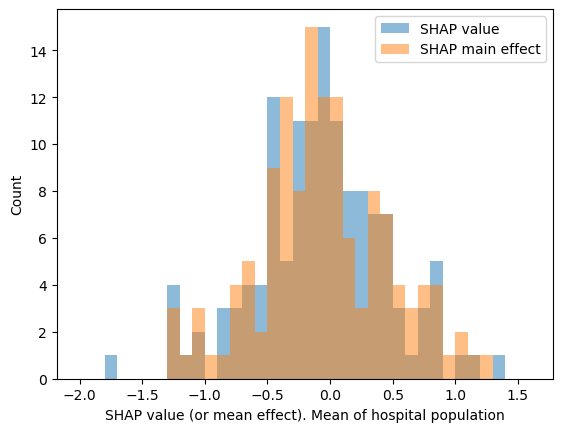

In [32]:
import random
import numpy
from matplotlib import pyplot

x = df_hosp_plot["mean SHAP value"]
y = df_hosp_plot["mean SHAP main effect"]

bins = np.arange(-2.0, 1.7, 0.1)

plt.hist(x, bins, alpha=0.5, label='SHAP value')
plt.hist(y, bins, alpha=0.5, label='SHAP main effect')
plt.legend(loc='upper right')
plt.ylabel('Count')
plt.xlabel('SHAP value (or mean effect). Mean of hospital population')
plt.savefig(f'./output/{notebook}_{model_text}_hosp_shap_value_and_main_effect_hist.jpg', dpi=300,
    bbox_inches='tight', pad_inches=0.2)
plt.show()

Plot scatter plot of comparison between average hospital SHAP value and predicted 10k thrombolysis use. (and average SHAP main effect with predicted 10k thrombolysis use).

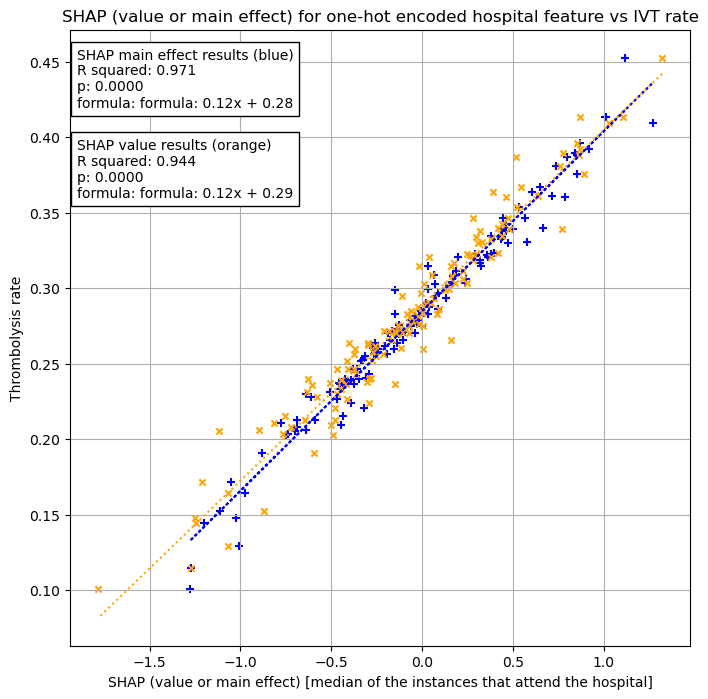

In [33]:
# Setup data for chart
x1 = df_hosp_plot['mean SHAP main effect']
x2 = df_hosp_plot['mean SHAP value']
y = df_hosp_plot['Thrombolysis rate']

# Fit a regression line to the x1 points
slope1, intercept1, r_value1, p_value1, std_err1 = \
    stats.linregress(x1, y)
r_square1 = r_value1 ** 2
y_pred1 = intercept1 + (x1 * slope1)

# Fit a regression line to the x2 points
slope2, intercept2, r_value2, p_value2, std_err2 = \
    stats.linregress(x2, y)
r_square2 = r_value2 ** 2
y_pred2 = intercept2 + (x2 * slope2)

# Create scatter plot with regression line
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.scatter(x1, y, color = "blue", marker="+", s=30)
ax.scatter(x2, y, color = "orange", marker="x", s=20)

ax.plot (x1, y_pred1, color = 'blue', linestyle=':')
f1 = ('formula: ' + str("{:.2f}".format(slope1)) + 'x + ' + 
      str("{:.2f}".format(intercept1)))
text1 = (f'SHAP main effect results (blue)\nR squared: {r_square1:.3f}\np: '
         f'{p_value1:0.4f}\nformula: {f1}')
ax.text(-1.9, 0.42, text1, 
         bbox=dict(facecolor='white', edgecolor='black'))

ax.plot (x2, y_pred2, color = 'orange', linestyle=':')
f2 = ('formula: ' + str("{:.2f}".format(slope2)) + 'x + ' + 
      str("{:.2f}".format(intercept2)))
text2 = (f'SHAP value results (orange)\nR squared: {r_square2:.3f}\np: '
         f'{p_value2:0.4f}\nformula: {f2}')
ax.text(-1.9, 0.36, text2, 
         bbox=dict(facecolor='white', edgecolor='black'))

ax.set_xlabel("SHAP (value or main effect) "
              "[median of the instances that attend the hospital]")
ax.set_ylabel('Thrombolysis rate')
ax.set_title("SHAP (value or main effect) for one-hot encoded hospital feature "
             "vs IVT rate")
plt.grid()

plt.savefig(f'./output/{notebook}_{model_text}'
            f'_attended_hosp_shap_value_and_maineffect_vs_ivt_rate.jpg', 
            dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()


## Observations

* The 10k cohort model had an accuracy of 85.2%, in line with accuracy from k-fold testing.
* The predicted thrombolysis use in the 10k cohort of patients ranged from 10% to 45%.
* Only 10% of the variability in hospital thrombolysis rate can be explained by the hospital admission rate.
* Nearly 92% of the variability in 10k hospital thrombolysis rate can be explained by the average hospital SHAP value.

It is easier to find majority agreement on who not to thrombolyse than who to thrombolyse. For example:

 * 87.4% of all patients have a treatment decision that is agreed by 80% hospitals
 * Of those who were not given thrombolysis, 84.1% had agreement by 80% hospitals
 * Of those who were given thrombolysis, 78.8% had agreement by 80% hospitals
 
 Thrombolysis rate of 10k cohort correlates weakly with unit size.
 
 10k thrombolysis rate correlates closely with average hospital SHAP value.